# LangGraph

In [ ]:
# pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph

In [1]:
import openai
import os
import getpass

In [2]:
# Set up the OpenAI API key
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [22]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import Graph, StateGraph
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [23]:
# Define the state
class AgentState(TypedDict):
    tweet: str
    reflection: str
    improved_tweet: str

In [24]:
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini")

In [25]:
# Define the prompt templates
reflection_template = PromptTemplate.from_template(
    """
    Analyze the following tweet and provide a reflection on how it can be improved:
    Tweet: {tweet}
    
    Consider aspects such as clarity, engagement, and brevity. Provide specific suggestions.
    """
)

In [26]:
improve_tweet_template = PromptTemplate.from_template(
    """
    Given the original tweet and the reflection, provide an improved version of the tweet:
    
    Original tweet: {tweet}
    Reflection: {reflection}
    
    Improved tweet:
    """
)

In [27]:
# Define the nodes
def reflect(state: AgentState) -> AgentState:
    chain = reflection_template | llm | StrOutputParser()
    reflection = chain.invoke({"tweet": state['tweet']})
    state['reflection'] = reflection
    return state

In [28]:
def improve_tweet(state: AgentState) -> AgentState:
    chain = improve_tweet_template | llm | StrOutputParser()
    improved_tweet = chain.invoke({"tweet": state['tweet'], "reflection": state['reflection']})
    state['improved_tweet'] = improved_tweet
    return state

In [29]:
# Define the graph
workflow = StateGraph(AgentState)

In [30]:
# Add nodes to the graph
workflow.add_node("reflect", reflect)
workflow.add_node("improve_tweet", improve_tweet)

In [31]:
# Add edges to the graph
workflow.add_edge("reflect", "improve_tweet")

In [32]:
# Set the entry point
workflow.set_entry_point("reflect")

In [33]:
# Compile the graph
graph = workflow.compile()

In [34]:
# Function to run the graph
def improve_tweet_with_reflection(tweet: str) -> str:
    result = graph.invoke({"tweet": tweet})
    return result['improved_tweet']

In [35]:
# Example usage
if __name__ == "__main__":
    original_tweet = "I think AI is cool and will change everything."
    improved_tweet = improve_tweet_with_reflection(original_tweet)
    print(f"Original tweet: {original_tweet}")
    print(f"Improved tweet: {improved_tweet}")

Original tweet: I think AI is cool and will change everything.
Improved tweet: "AI is revolutionizing industries like healthcare and education. Which area do you think will change the most? #AI #FutureTech"


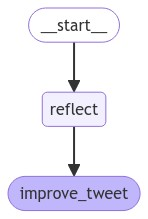

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass